In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
import sys
sys.path.append("../")

In [4]:
import editdistance as ed
import utils.hierarcical_utils as hu

In [5]:
import utils.viz_utils as vu
import utils.hamiltonian_utils as hamu
from importlib import reload
vu = reload(vu)
hamu = reload(hamu)

In [6]:
arrays = pickle.load(open("../../data/clostr_res/arrays_110", 'rb'))
cl_to_n = pickle.load(open("../../data/clostr_res/110_cl_to_n", 'rb'))
n_to_cl_full = pickle.load(open("../../data/clostr_res/n_to_cl_110", 'rb'))
nd = pickle.load(open("../../data/clostr_res/110_nd", 'rb'))
gr = np.load("../../data/clostr_res/110.npy")

In [7]:

n_to_cl = {}
for item in cl_to_n.items():
    n_to_cl[item[1]] = item[0]

In [8]:
cl_to_n_full = {}
for item in n_to_cl_full.items():
    cl_to_n_full[item[1]] = item[0]

In [9]:
with open("../../data/answers/Clo_009089.txt", 'r') as f:
    lines1 = [x[:-2] for x in f.readlines()]
with open("../../data/answers/Clo_013316.txt", 'r') as f:
    lines2 = [x[:-2] for x in f.readlines()]

In [14]:
lines1_s = [x.split(",")[1:] for x in lines1]
lines2_s = [x.split(",")[1:] for x in lines2]

In [15]:
answ1 = [[cl_to_n[hu.find_closest(cl_to_n, x)[1]] for x in y.split(',')[1:]] for y in lines1]

In [16]:
answ2 = [[cl_to_n[hu.find_closest(cl_to_n, x)[1]] for x in y.split(',')[1:]] for y in lines2]

In [38]:
rep = 'GTTTTATATTAACTAAGTGGTATGTAAAT'

In [11]:
arrays, weights = hamu.restore_arrays(gr, 10)

In [17]:
arrays[0]

[138, 182, 98, 6, 96, 31, 37, 146, 115, 39, 211, 126, 112, 56, 174, 147, 93]

In [26]:
answ = answ1 + answ2
answ_m = np.array([10] * len(answ1) + [1] * len(answ2))

In [32]:
arrays_m = np.zeros(len(arrays))

In [35]:
for i, arr in enumerate(arrays):
    arrays_m[i] = answ_m[hamu.search_best_alignment(arr, answ, 2)[1]]

In [36]:
arrays_m

array([10., 10., 10., 10., 10., 10.,  1., 10., 10., 10.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [79]:
arrays_str = [rep + rep.join([n_to_cl[x] for x in arr]) + rep for arr in arrays]

In [40]:
for i, arr in enumerate(arrays):
    with open("../../data/seqs/arr" + str(i), 'w') as f:
        f.write(rep + rep.join([n_to_cl[x] for x in arr]) + rep)

In [111]:
secondary = [0 for i in range(len(arrays))]
energy = [0 for i in range(len(arrays))]

In [152]:
import os
for f in os.listdir("../../data/seqs/answs/"):
    pos = int(f[3:])
    secondary[pos] = [x[:-1] for x in open("../../data/seqs/answs/" + f).readlines()][1].split(" ")[0]
    energy[pos] = float([x[:-1] for x in open("../../data/seqs/answs/" + f)
                         .readlines()][1].split(" ")[-1].translate({ord(')'):None,ord('('):None}))
    

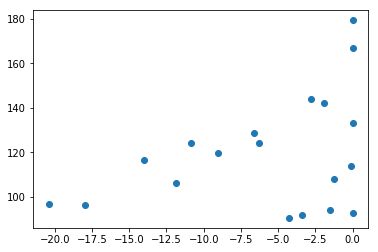

In [153]:
plt.scatter(energy, [np.mean(x) for x in arrays])
#plt.scatter(energy, [np.median(x) for x in arrays])
# plt.scatter(energy, [np.max(x) for x in arrays])
# plt.scatter(energy, [np.min(x) for x in arrays])

In [205]:
def split_by_repeat(single_array_str, single_secondary, single_weights, repeat, c = 1, window = 0):
    spacers = single_array_str.split(rep)[1:-1]
    weights_elong = [0] + single_weights + [0]

    parts = []
    secondary_parts = []
    amp = []
    for i, sp in enumerate(spacers):
        pos = single_array_str.find(sp)
        start, end  = pos - window, pos + len(sp) + window
        
        parts.append(single_array_str[start:end])
        secondary_parts.append(single_secondary[start:end])
        amp.append((weights_elong[i] + weights_elong[i+1]) / c)

    return parts, secondary_parts, amp

In [210]:
X1, X2, Y  = [],[],[]
for arr, sc, w, c in zip(arrays_str, secondary, weights, arrays_m):
    x1, x2, y = split_by_repeat(arr, sc, w, rep, c)
    X1.extend(x1)
    X2.extend(x2)
    Y.extend(y)

In [215]:
for a,b in zip(X2, Y):
    print(b, a)

2109.9 ..((((....)))).......................
3693.0 ...........(((((......))))).........
4716.4 (..(((((.............................
5058.2 ...............(((((((((((..........
2788.9 ((((....))))(((..(((((((..((((((((.(
1284.3 .......((((((((((....((((((......))
1759.8 ...........)))..)))))))..)))..........
2680.0 ....................................
9848.7 ..........)))))..))..................
11391.0 ....................................
4114.5 ...................................
2166.8 ....................................
1850.7 ....................((((((((........
4837.0 ........................)))))))))))..
5690.7 .................(((.....))).......
2528.2 ..........)))))..)))).......))).)))
758.9 ....................................
4394.5 ........................((((((.(((((((
6475.5 .........))))))........(((....)))...
3526.0 ...........................)))))))).
5881.9 (((((............(((.....)))........
6010.8 .))))))))).....))))))))...))))))....
2763.6 ...................((

In [218]:
def x2_to_vector_1(x2, max_len=41):
    vec = np.zeros(max_len)
    for i,c in enumerate(x2):
        if c=='(':
            vec[i] = -1
        elif c == ')':
            vec[i] = 1
    return vec

In [223]:
X2_1 = np.stack([x2_to_vector_1(x) for x in X2])

In [228]:
X2_1.shape

(175, 41)

In [241]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import multilayer_perceptron

In [238]:
lr.fit(X2_1[:120], Y[:120])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [239]:
np.sqrt(np.mean((lr.predict(X2_1[120:]) - Y[120:])**2))

1742.7716653011257

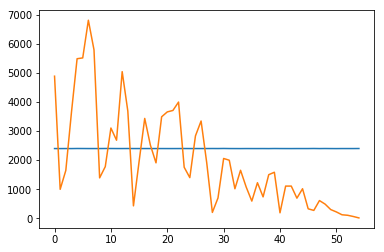

In [240]:
plt.plot(lr.predict(X2_1[120:]))
plt.plot(Y[120:])

In [10]:
repeat = 'GTTTTATATTAACTAAGTGGTATGTAAAT'
repeat1 = "GTTTTATATTAACTAAGTGGTATGTAAAG" 
ed.eval(repeat, repeat1)

1

In [90]:
weights1 = [[nd[n_to_cl[x]] for x in y] for y in answ1]
weights2 = [[nd[n_to_cl[x]] for x in y] for y in answ2]

In [52]:
strs1 = [repeat + repeat.join(x) + repeat for x in lines1_s]
strs2 = [repeat + repeat.join(x) + repeat for x in lines2_s]

In [82]:
for a,b in zip([x[1].split()[1] for x in secondary_1], [np.median(x) for x in weights1]):
    int(a[1:-1]), b

ValueError: invalid literal for int() with base 10: '-178.40'

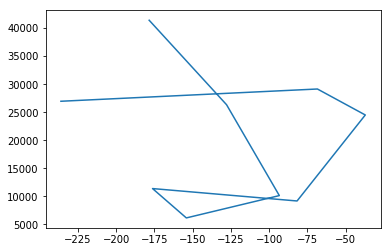

In [86]:
plt.plot([float(x[1].split()[1][1:-1]) for x in secondary_1], [np.median(x) for x in weights1])

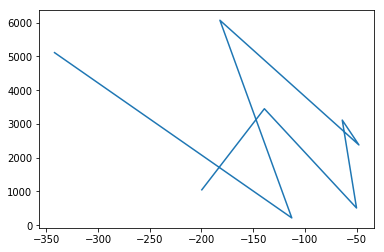

In [91]:
plt.plot([float(x[1].split()[1][1:-1]) for x in secondary_2], [np.median(x) for x in weights2])

In [19]:
arrays, weights = hamu.restore_arrays(gr, 0)